# Bike Sharing Case Study

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.


They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands


Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 



In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import calendar

# Suppress warnings
warnings.filterwarnings('ignore')

### Reading and Understanding Dataset

In [133]:
df = pd.read_csv("day.csv")

In [134]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [135]:
df.shape

(730, 16)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### This Dataset having 730 rows and 30 Columns 

In [137]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### This Dataset does not having any null/missing values

In [138]:
df.duplicated().sum()

0

#### This Dataset does not have any duplicates values. 

### Data Cleaning  which are not useful for analysis

In [139]:
#dropping the columns which are not required for analysis
df.drop(["instant", "dteday", "casual", "registered"],axis=1,inplace=True)

In [140]:
#checkign unique count for each column
df.nunique()

season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
cnt           695
dtype: int64

### Mapping Categorial Features to appropriate String Values

In [141]:

df["season"] = df["season"].map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})
df["mnth"] = df["mnth"].apply(lambda x: calendar.month_abbr[x])
df["weekday"] = df["weekday"].map({0: 'Sunday',1: 'Monday',2: 'Tuesday',3: 'Wednesday',4: 'Thursday',5: 'Friday',6: 'Saturday'})
df["weathersit"] = df["weathersit"].map({1:'Clear',2:'Mist & Cloudy', 3:'Light Snow & Rain',4:'Heavy Snow & Rain'})


In [142]:
# printing dataset info after mapping categorial features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


### Outlier Analysis

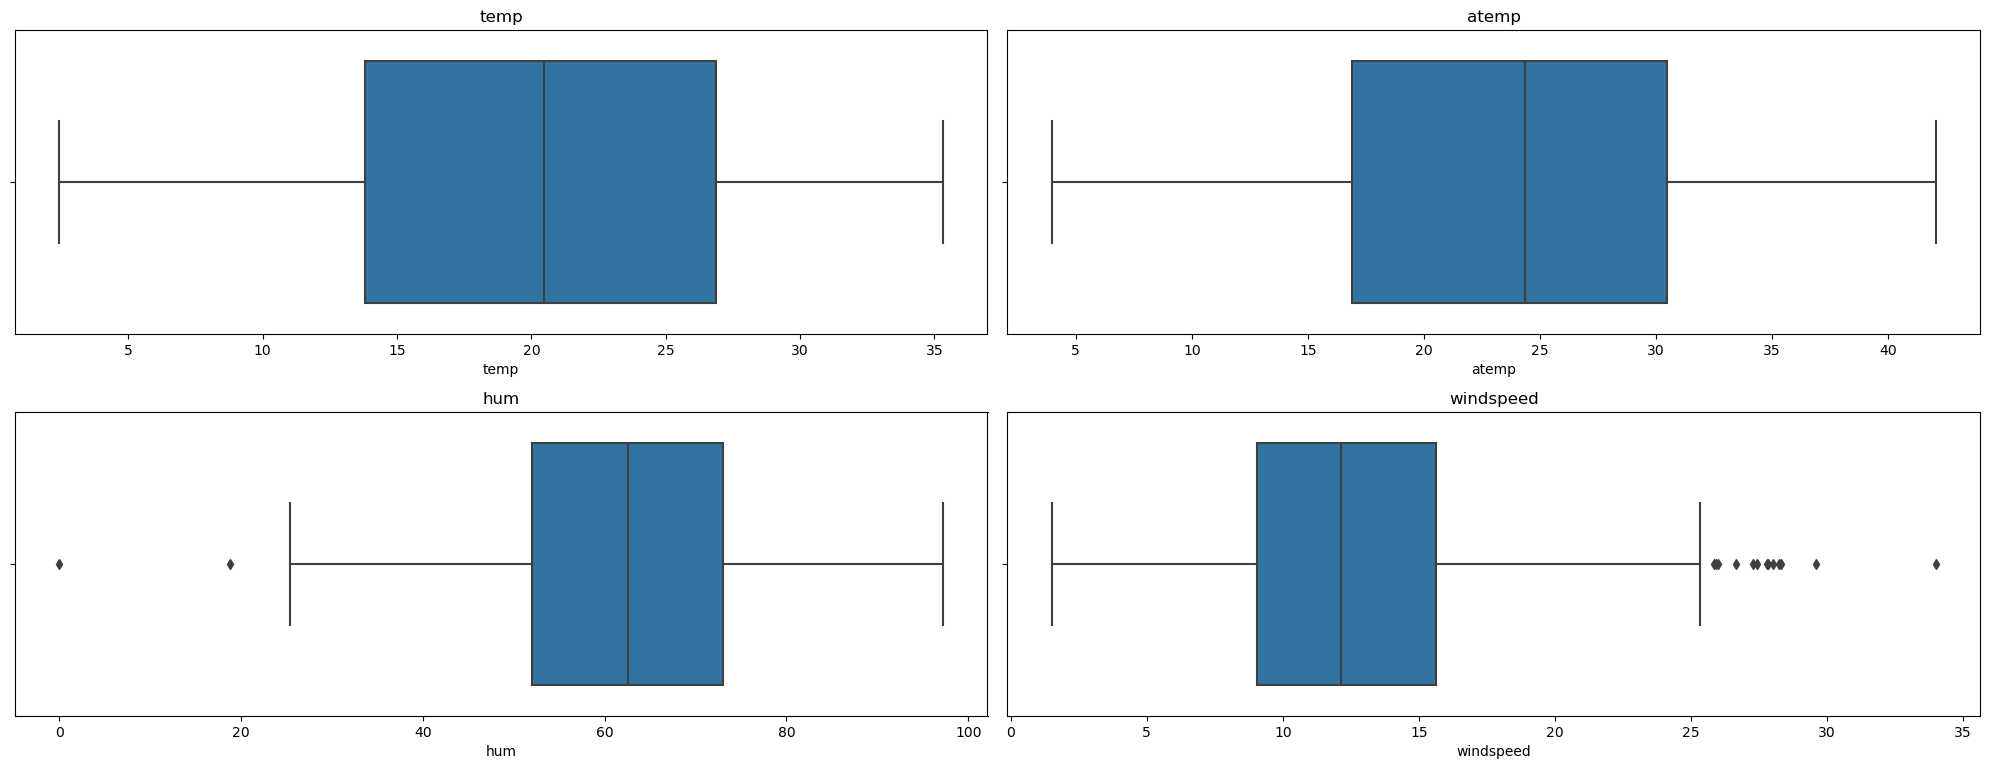

In [143]:
num_col = ["temp","atemp", "hum", "windspeed"]
def check_outlier():
        
    # Assuming num_col is a list of column names and df is your dataframe
    i = 1  # Number of rows for subplots
    j = 1  # Current subplot number
    fig = plt.figure(figsize=(20, 15))  # Create a figure with appropriate size
    
    for col in num_col:
        try:
            plt.subplot(4, 2, j)  # Create subplots in a grid of 4 rows, 2 columns
            sns.boxplot(x=df[col])
            plt.title(col)  # Add title to each subplot
            j = j + 1
            
            # When j exceeds the available subplot positions (8), show the plot and reset
            if j > 8:
                plt.tight_layout()
                plt.show()
                fig = plt.figure(figsize=(20, 15))  # Create a new figure for the next set
                j = 1  # Reset subplot index
        except:
            print("Error for column", col)
    
    # Show the last set of plots
    if j != 1:
        plt.tight_layout()
        plt.show()

check_outlier()

#### This Dataset have some outliers for windspeed column

### Visualizing Numerical Columns


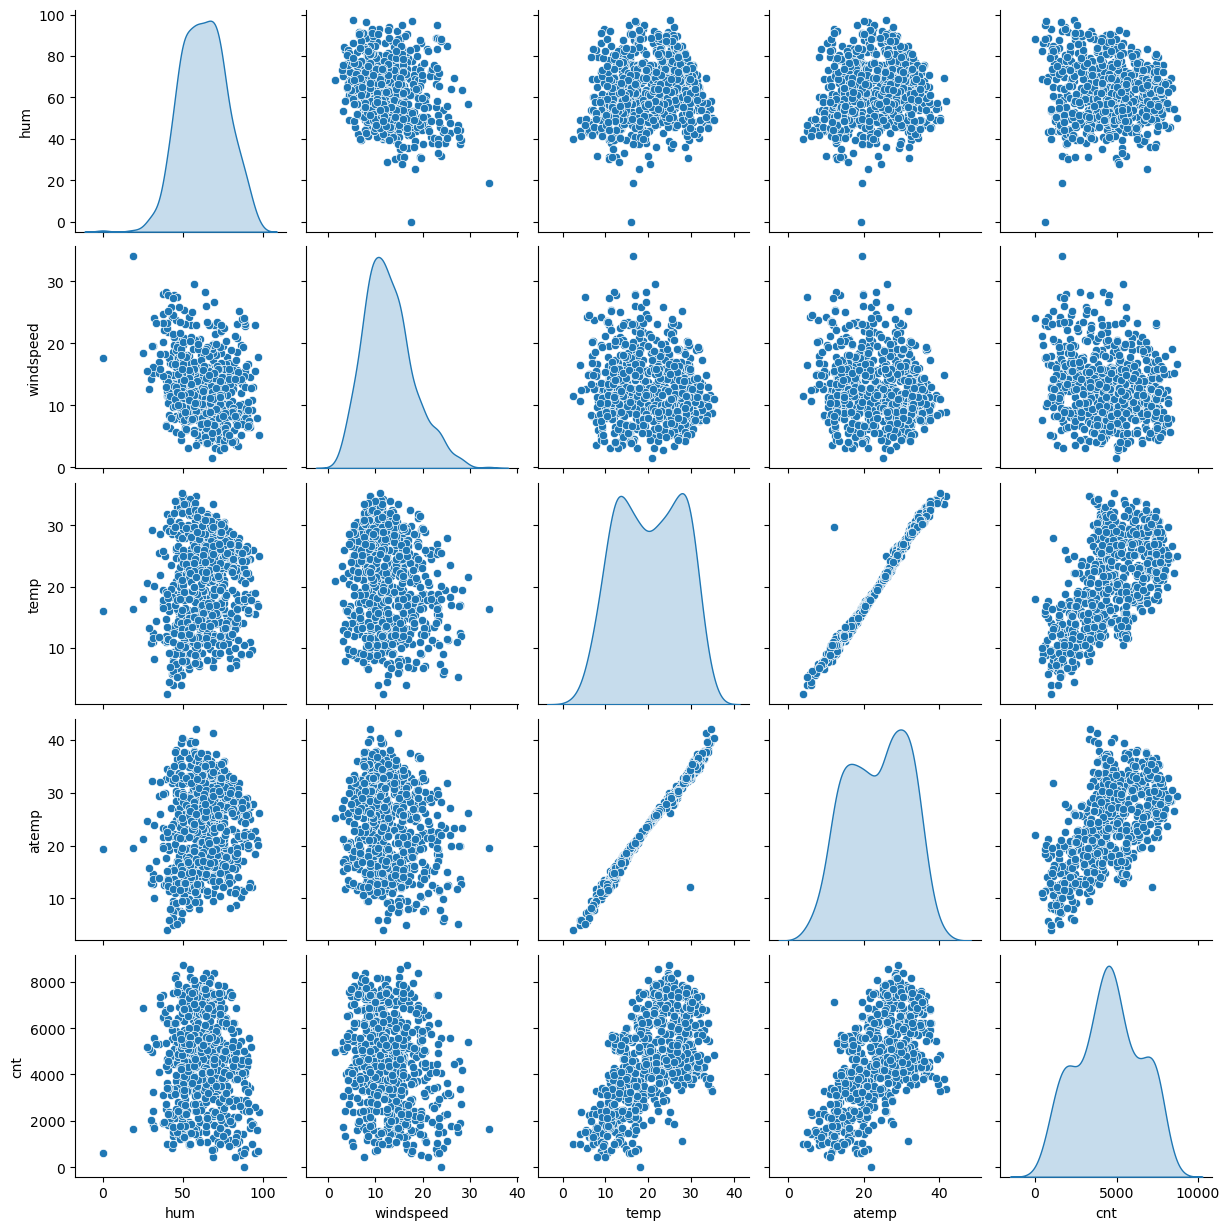

In [144]:
numeric_col=df[[ 'hum', 'windspeed', 'temp', 'atemp','cnt']]

sns.pairplot(numeric_col, diag_kind='kde')
plt.show()

### Univariate Analysis

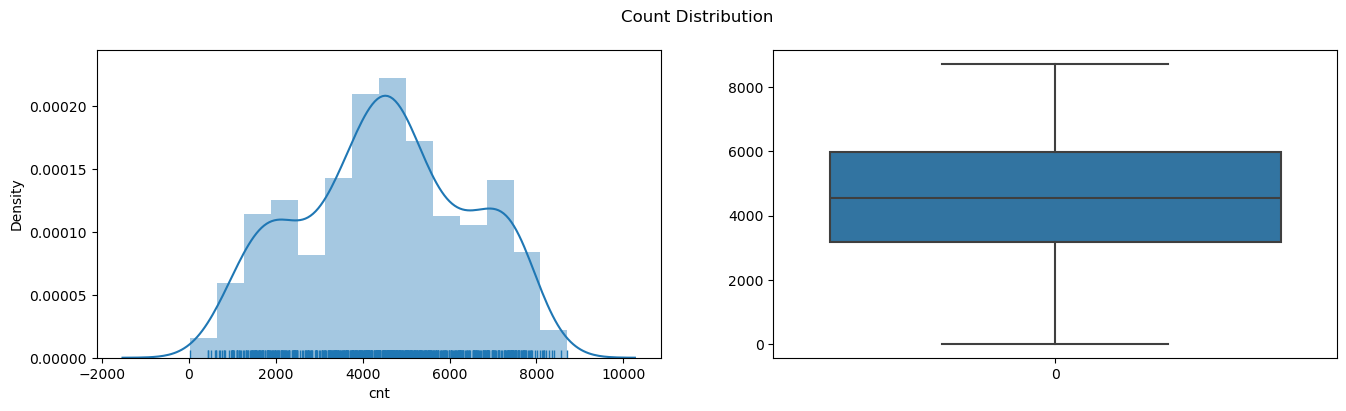

In [145]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.distplot(a=df.cnt, rug=True)
plt.subplot(1,2,2)
sns.boxplot(data=df.cnt)
plt.suptitle('Count Distribution')
plt.show()

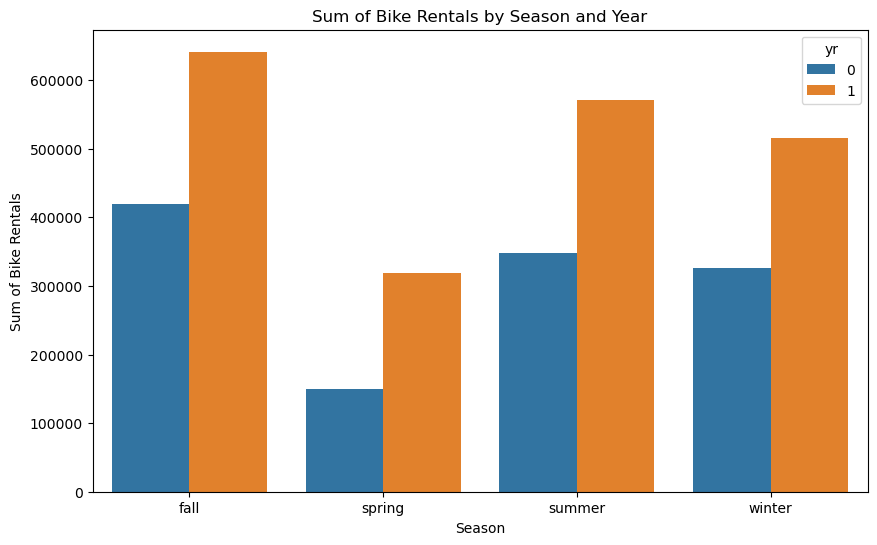

In [151]:
# Convert the 'yr' column to string or category
# Ensure proper column types

grouped_data = df.groupby(['season', 'yr'])['cnt'].sum().reset_index()

grouped_data["yr"] = grouped_data["yr"].astype(str)
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="season", y="cnt", hue="yr", data=grouped_data, estimator="sum")

# Add labels and title
plt.xlabel("Season")
plt.ylabel("Sum of Bike Rentals")
plt.title("Sum of Bike Rentals by Season and Year")

# Show plot
plt.show()


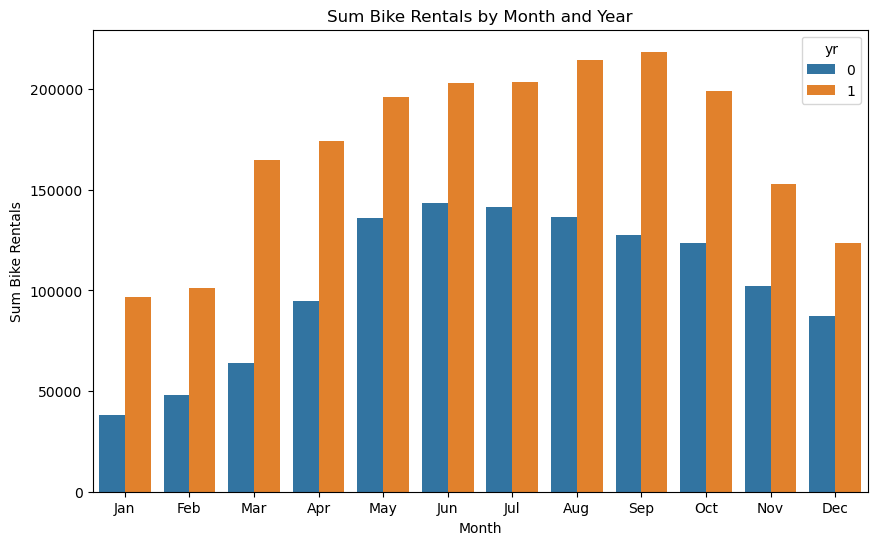

In [153]:

grouped_data = df.groupby(['mnth', 'yr'])['cnt'].sum().reset_index()
# Convert 'yr' to string for the hue
grouped_data["yr"] = grouped_data["yr"].astype(str)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="mnth", y="cnt", hue="yr", data=grouped_data, order=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

# Add labels and title
plt.xlabel("Month")
plt.ylabel("Sum Bike Rentals")
plt.title("Sum Bike Rentals by Month and Year")

# Show plot
plt.show()


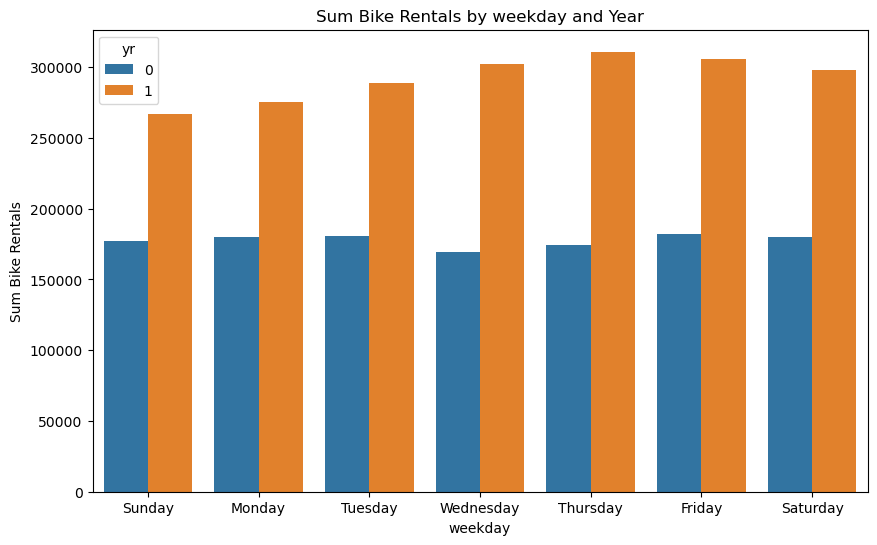

In [154]:
df["yr"] = df["yr"].astype(str)  # Ensure 'yr' is a string before grouping
grouped_data = df.groupby(["weekday", "yr"])["cnt"].sum().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="weekday", y="cnt", hue="yr", data=grouped_data, order=["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])

# Add labels and title
plt.xlabel("weekday")
plt.ylabel("Sum Bike Rentals")
plt.title("Sum Bike Rentals by weekday and Year")

# Show plot
plt.show()


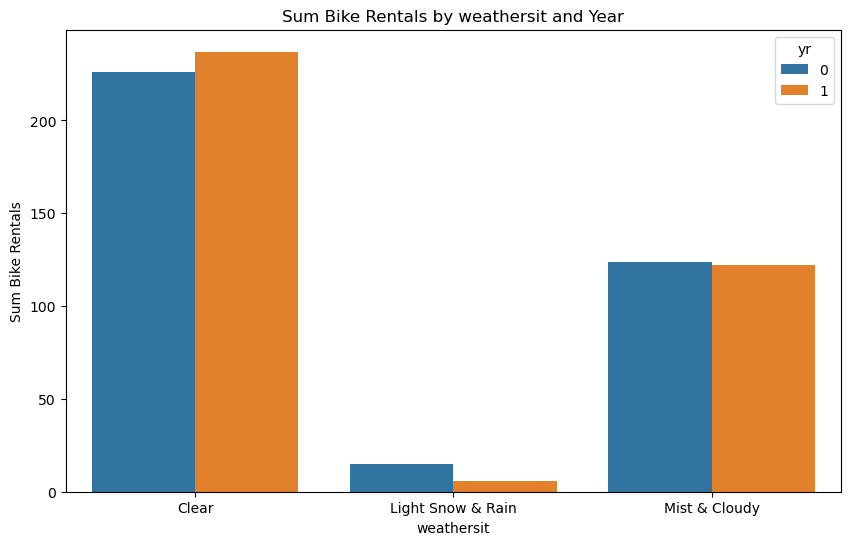

In [155]:
grouped_data = df.groupby(["weathersit", "yr"])["cnt"].count().reset_index()
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="weathersit", y="cnt", hue="yr", data=grouped_data)

# Add labels and title
plt.xlabel("weathersit")
plt.ylabel("Sum Bike Rentals")
plt.title("Sum Bike Rentals by weathersit and Year")

# Show plot
plt.show()


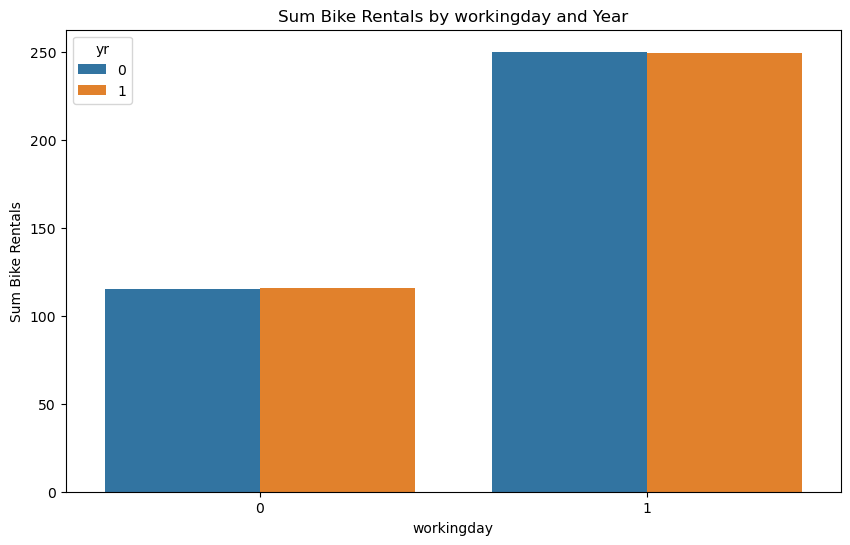

In [156]:
grouped_data = df.groupby(["workingday", "yr"])["cnt"].count().reset_index()
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="workingday", y="cnt", hue="yr", data=grouped_data)

# Add labels and title
plt.xlabel("workingday")
plt.ylabel("Sum Bike Rentals")
plt.title("Sum Bike Rentals by workingday and Year")

# Show plot
plt.show()


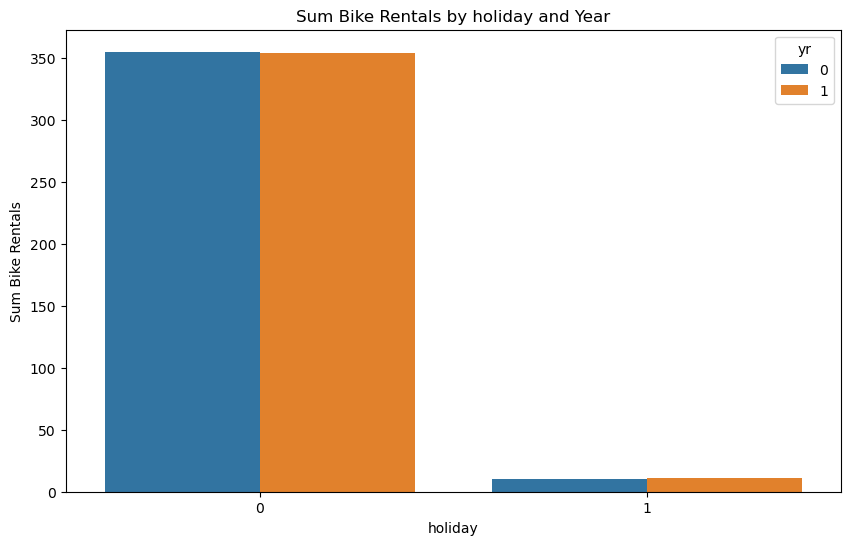

In [157]:
grouped_data = df.groupby(["holiday", "yr"])["cnt"].count().reset_index()
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="holiday", y="cnt", hue="yr", data=grouped_data)

# Add labels and title
plt.xlabel("holiday")
plt.ylabel("Sum Bike Rentals")
plt.title("Sum Bike Rentals by holiday and Year")

# Show plot
plt.show()


### Bivariate Analysis

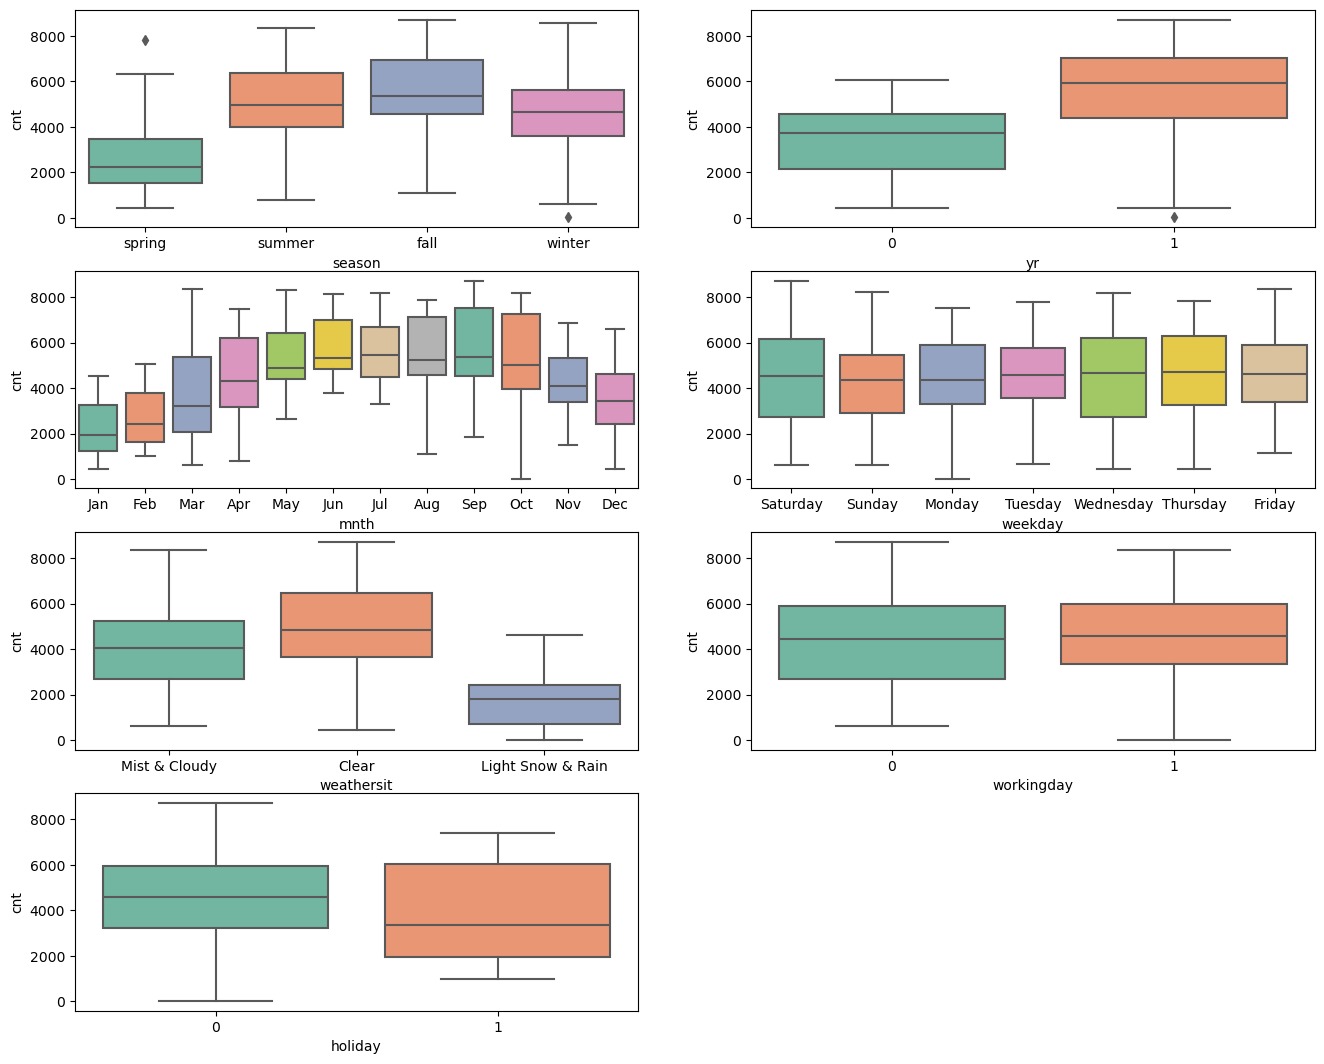

In [158]:
palette = sns.color_palette("Set2", n_colors=15)
plt.figure(figsize=(16,13))

j=1

cat_cols = ["season", "yr", "mnth", "weekday", "weathersit","workingday","holiday"]
for col in cat_cols:
    plt.subplot(4,2,j)
    sns.boxplot(x=col, y='cnt',data=df, palette=palette)
    j = j + 1
plt.show()


### Corelation 

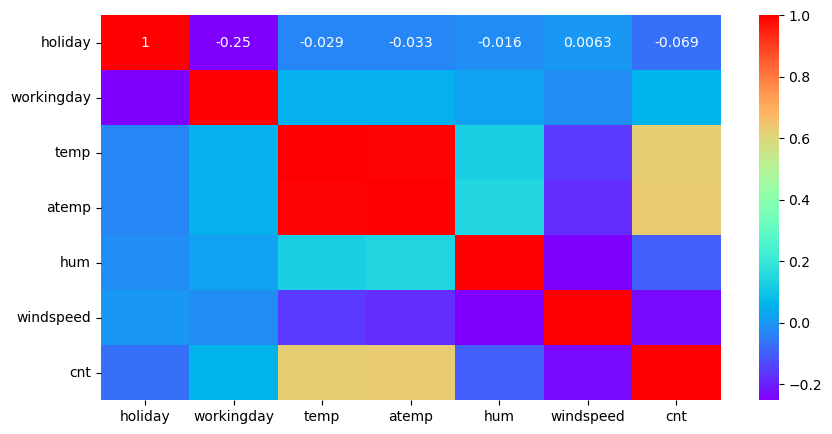

In [159]:
# List of numerical columns
num_col = [] 

for col in df.columns:
	if((df[col].dtype == "int32") or (df[col].dtype == "int64") or (df[col].dtype == "float32") or (df[col].dtype == "float64") ):
		  num_col.append(col)

fig=plt.figure(figsize=(10,5))
sns.heatmap(df[num_col].corr(),annot=True,cmap="rainbow")
plt.show()

In [160]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sunday,0,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Monday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### Get Dummy Values for Regression

In [161]:
df = pd.get_dummies(data=df, columns=["season","mnth","weekday","weathersit"], drop_first=True, dtype=int)
print(len(df.columns))

30


In [162]:
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weathersit_Light Snow & Rain',
       'weathersit_Mist & Cloudy'],
      dtype='object')

In [163]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,1,0,0


### Splitting data into train and test 

In [164]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)

In [165]:
# verifying train and split data size
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


### Rescaling the Features Using MinMaxScaler      (Normalization)

In [166]:
scaler = MinMaxScaler()

num_cols = ["temp", "atemp", "hum", "windspeed","cnt"]

df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

In [170]:
# verifying the min and max value for each features.
df_train.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,...,0.084314,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098
std,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,...,0.278131,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [171]:
non_numeric_columns = df_train.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['yr'], dtype='object')


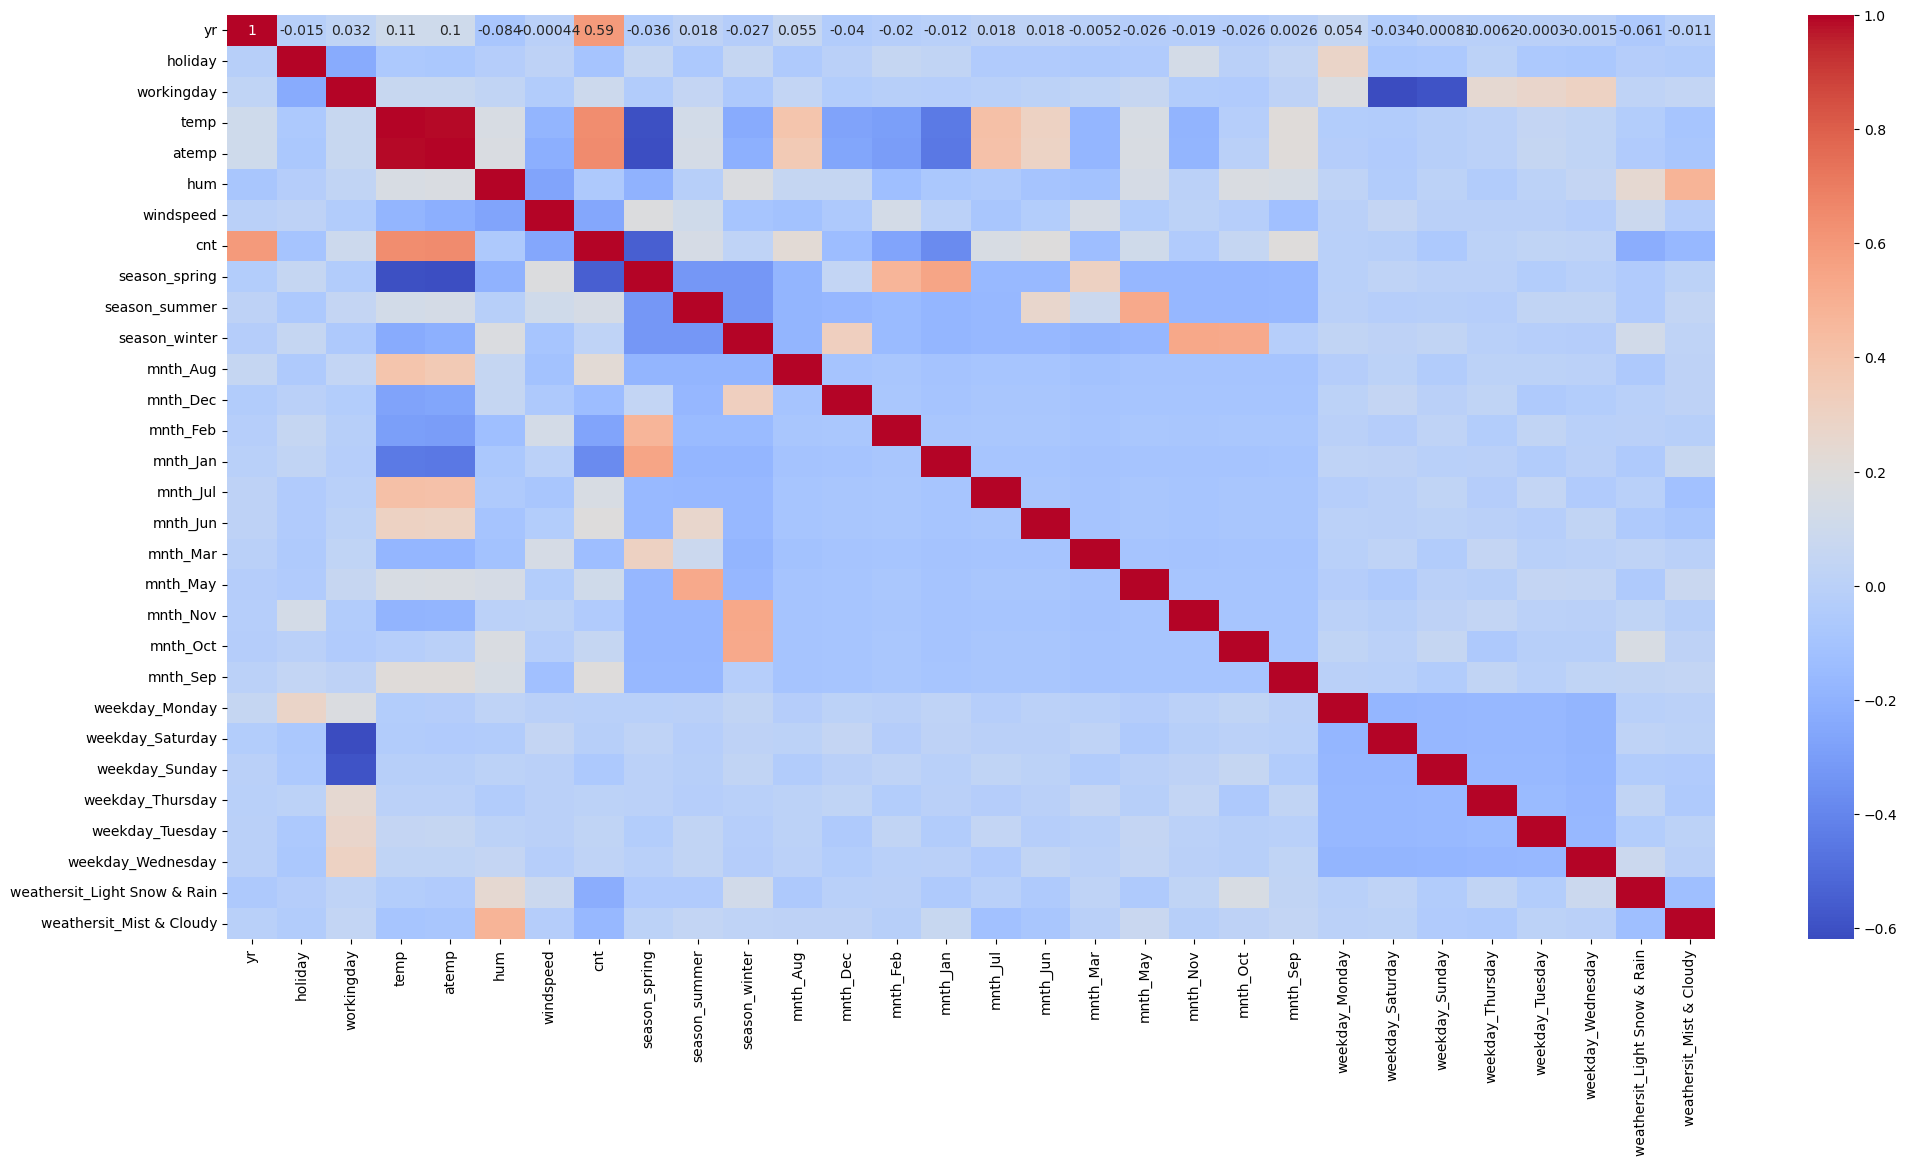

In [172]:
# checking corelation 
fig = plt.figure(figsize=(24, 12))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm")
plt.show()


### Build Model Using Recursive Feature Elimination (RFE)

In [173]:
y_train = df_train.pop('cnt')
X_train = df_train

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=15)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [174]:
#RFE ranking for each features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 7),
 ('mnth_Dec', False, 3),
 ('mnth_Feb', False, 4),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 14),
 ('mnth_Mar', False, 15),
 ('mnth_May', False, 6),
 ('mnth_Nov', False, 2),
 ('mnth_Oct', False, 13),
 ('mnth_Sep', True, 1),
 ('weekday_Monday', False, 9),
 ('weekday_Saturday', True, 1),
 ('weekday_Sunday', False, 8),
 ('weekday_Thursday', False, 11),
 ('weekday_Tuesday', False, 10),
 ('weekday_Wednesday', False, 12),
 ('weathersit_Light Snow & Rain', True, 1),
 ('weathersit_Mist & Cloudy', True, 1)]

In [175]:
# RFE selected columns
rfe_selected_cols = list(X_train.columns[rfe.support_])

# columns selected By RFE
print(rfe_selected_cols)

['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring', 'season_summer', 'season_winter', 'mnth_Jan', 'mnth_Jul', 'mnth_Sep', 'weekday_Saturday', 'weathersit_Light Snow & Rain', 'weathersit_Mist & Cloudy']


In [176]:
X_train[rfe_selected_cols]

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Jan,mnth_Jul,mnth_Sep,weekday_Saturday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,1,0,1
728,1,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,1,0,1
111,0,0,1,0.345824,0.751824,0.380981,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,1,0,1,0.863973,0.679690,0.187140,0,0,0,0,0,0,0,0,0
53,0,0,1,0.202618,0.435939,0.111379,1,0,0,0,0,0,0,0,0
350,0,0,0,0.248216,0.577930,0.431816,0,0,1,0,0,0,1,0,1
79,0,0,1,0.462664,0.759870,0.529881,0,1,0,0,0,0,0,0,1


In [177]:
# X_train_rfe will contain only 15 columns which are selected by RFE
X_train_rfe = X_train[rfe_selected_cols]

### Build Model


In [178]:
def build_model(X):
  X_train_sm = sm.add_constant(X)
  lm = sm.OLS(y_train, X_train_sm).fit()
  print(lm.summary())
  
def get_vif(X):
    vif_df = X
    vif = pd.DataFrame()
    vif['Features'] = vif_df.columns
    vif['VIF'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))  

## MODEL-1

In [183]:
print(X_train_rfe.dtypes)
print(y_train.dtypes)



yr                               object
holiday                           int64
workingday                        int64
temp                            float64
hum                             float64
windspeed                       float64
season_spring                     int32
season_summer                     int32
season_winter                     int32
mnth_Jan                          int32
mnth_Jul                          int32
mnth_Sep                          int32
weekday_Saturday                  int32
weathersit_Light Snow & Rain      int32
weathersit_Mist & Cloudy          int32
dtype: object
float64


In [184]:
# Convert all columns of X_train_rfe to numeric, forcing errors to NaN
X_train_rfe = X_train_rfe.apply(pd.to_numeric, errors='coerce')

# Convert y_train to numeric
y_train = pd.to_numeric(y_train, errors='coerce')


In [185]:
print(X_train_rfe.head())
print(y_train.head())
print(X_train_rfe.dtypes)


     yr  holiday  workingday      temp       hum  windspeed  season_spring  \
576   1        0           1  0.815169  0.725633   0.264686              0   
426   1        0           0  0.442393  0.640189   0.255342              1   
728   1        0           0  0.245101  0.498067   0.663106              1   
482   1        0           0  0.395666  0.504508   0.188475              0   
111   0        0           1  0.345824  0.751824   0.380981              0   

     season_summer  season_winter  mnth_Jan  mnth_Jul  mnth_Sep  \
576              0              0         0         1         0   
426              0              0         0         0         0   
728              0              0         0         0         0   
482              1              0         0         0         0   
111              1              0         0         0         0   

     weekday_Saturday  weathersit_Light Snow & Rain  weathersit_Mist & Cloudy  
576                 0                           

In [186]:
# Add constant
X_train_sm = sm.add_constant(X_train_rfe)

# Fit the OLS model
lm = sm.OLS(y_train, X_train_sm).fit()

# Print model summary
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          4.22e-191
Time:                        05:35:04   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [187]:
get_vif(X_train_rfe)

                        Features    VIF
4                            hum  29.37
3                           temp  17.78
2                     workingday   5.31
5                      windspeed   4.73
6                  season_spring   4.53
8                  season_winter   3.46
7                  season_summer   2.85
14      weathersit_Mist & Cloudy   2.29
0                             yr   2.09
12              weekday_Saturday   1.98
9                       mnth_Jan   1.67
10                      mnth_Jul   1.59
11                      mnth_Sep   1.39
13  weathersit_Light Snow & Rain   1.24
1                        holiday   1.18


In [188]:
# need to drop hum  as its VIF is 29.37
X_train_rfe.drop("hum", axis=1, inplace=True)

## MODEL - 2  

In [191]:
build_model(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Tue, 24 Dec 2024   Prob (F-statistic):          1.60e-188
Time:                        05:36:09   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [192]:
get_vif(X_train_rfe)

                        Features   VIF
3                           temp  7.07
2                     workingday  5.24
4                      windspeed  4.68
5                  season_spring  3.07
6                  season_summer  2.34
0                             yr  2.08
7                  season_winter  1.98
11              weekday_Saturday  1.97
8                       mnth_Jan  1.62
9                       mnth_Jul  1.59
13      weathersit_Mist & Cloudy  1.58
10                      mnth_Sep  1.35
1                        holiday  1.17
12  weathersit_Light Snow & Rain  1.09


####  Column temp with cnt column corelation is 0.65 seems to be good hence dropping this feature is not recommended. 

### Build the model with RFE and Manual Approach

In [193]:
lr1 = LinearRegression()
lr1.fit(X_train_rfe, y_train)

LinearRegression()

In [194]:
X_train_rfe

,yr,holiday,workingday,temp,windspeed,season_spring,season_summer,season_winter,mnth_Jan,mnth_Jul,mnth_Sep,weekday_Saturday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy
576,1,0,1,0.815169,0.264686,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.255342,1,0,0,0,0,0,1,0,1
728,1,0,0,0.245101,0.663106,1,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.188475,0,1,0,0,0,0,1,0,1
111,0,0,1,0.345824,0.380981,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,1,0,1,0.863973,0.187140,0,0,0,0,0,0,0,0,0
53,0,0,1,0.202618,0.111379,1,0,0,0,0,0,0,0,0
350,0,0,0,0.248216,0.431816,0,0,1,0,0,0,1,0,1
79,0,0,1,0.462664,0.529881,0,1,0,0,0,0,0,0,1


In [195]:
y_train_pred = lr1.predict(X_train_rfe)

### Residual Analysis on Actual Vs Predicted on Train Data

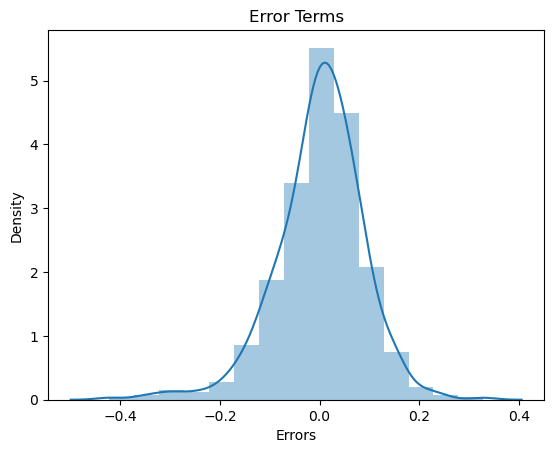

In [196]:
sns.distplot(y_train - y_train_pred, bins=15)
plt.title("Error Terms")
plt.xlabel("Errors")
plt.show()

### Verifying the Residuals using QQ Plot

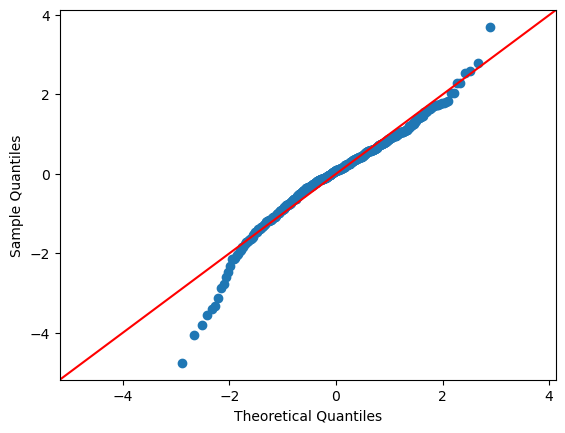

In [197]:
# Lets verify same using QQ Plot
sm.qqplot((y_train - y_train_pred), fit=True, line='45')
plt.show()

### Homoscedasticity 

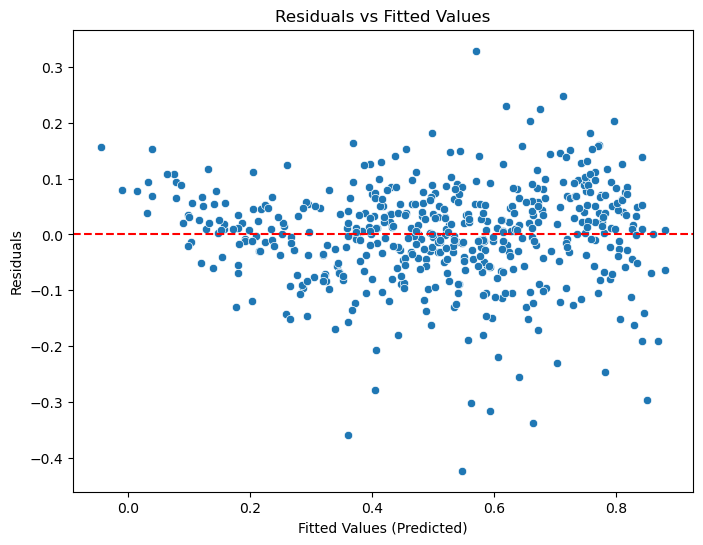

In [198]:
# Plotting the residuals vs fitted values
residuals = y_train - y_train_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predicted)')
plt.ylabel('Residuals')
plt.show()


### Calculating r2 score on training Data

In [199]:
r2_score(y_true= y_train, y_pred=y_train_pred)

0.8428227495513763

### Using MinMaxScaler on Test Data

In [200]:

df_test[num_cols] = scaler.transform(df_test[num_cols])

In [201]:
# verifying min max scaling have been applied. 
df_test.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light Snow & Rain,weathersit_Mist & Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,...,0.086364,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000,0.027273,0.318182
std,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,...,0.281541,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.163248,0.466833
min,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [202]:
y_test = df_test.pop("cnt")
X_test = df_test

y_test_pred= lr1.predict(X_test[X_train_rfe.columns])

### Calculating R2 score on testing Data

In [203]:
r2_score(y_pred=y_test_pred, y_true=y_test)

0.8050495669880955

## Evaluating the model

### Regression Plot on Test Data

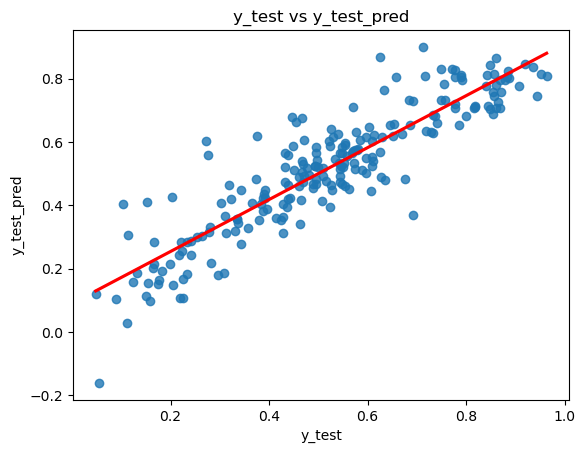

In [204]:
# Visualizing the fit on the test data

plt.figure()
sns.regplot(x=y_test, y=y_test_pred, ci=20, fit_reg=True, line_kws={"color": "red"})
plt.title('y_test vs y_test_pred')
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.show()

### Homoscedasticity on test Data

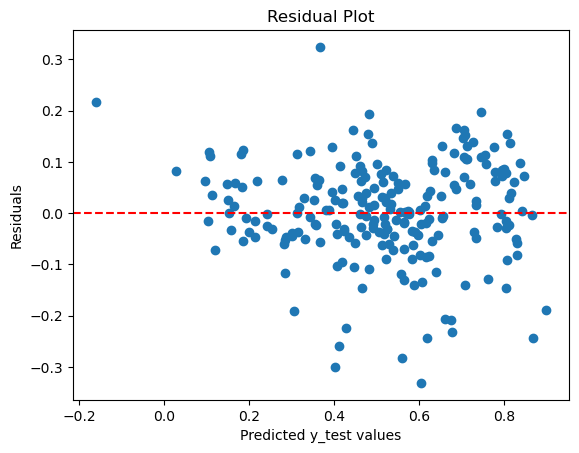

In [205]:
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted y_test values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()